In [2]:
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import multiprocessing
import numbers

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
if  comp_name == 'Ezequiels-MacBook-Pro.local':
    print 'Computer: ' + comp_name
    sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/Users','zeke','experiment')
else:
    print 'Computer: ' + 'server'
    sys.path.append('/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/','experiment')
    
import unitToolsv2
from data_handling import ephys_names as en
from data_handling.basic_plot import decim, plot_raster, make_psth, col_binned
from data_handling import data_load as dl
from data_handling.data_load import get_warping_parameters
from analysis import stimulus as st
from analysis import response_functions as rf


#load all the records, to not load all the records for every stimulus
fn = en.file_names(root = experiment_folder)
cells_path = os.path.join(fn.fold_exp_data, 'data_play')
uf = dl.list_cells(cells_path)
all_cells = [f for f in uf if f.find('ZKawakeM72_029')>-1]
all_cells = uf
#print all_cells
all_records = dl.load_cells(cells_path, all_cells)

#all_records = dl.load_cells(cells_path)

## create a stimulus and initialize it (load its responses)
high_2hydroxy = st.Odor(['2-hydroxyacetophenone','2hydroxyacetophenone'], 0.0051)
st_1 = st.Stimulus(high_2hydroxy, records = all_records, tags = {'light':1} )

#get the first response and plot it
warp = True
#st_1.responses['ZKawakeM72_013_e_010'].get_response_onset(warped=warp)
#rp = st_1.responses['ZKawakeM72_013_e_010'].plot(warped=warp)

#make all the odor stimuli
tags = {'light':1}
# {odor_name: [stim_aliases], conc, records, tags, extra_plot_pars}

all_odors_list = {'2-hydroxy_high': [['2-hydroxyacetophenone','2hydroxyacetophenone'], 0.0051, 
                  all_records, tags, {'color': '#9F000F', 'alpha': 1.}],
                  
                  '2-hydroxy_med': [['2-hydroxyacetophenone','2hydroxyacetophenone'], 2.97e-4,
                                    all_records, tags, {'color': '#F62217', 'alpha': .5}],
                  
                  '2-hydroxy_low': [['2-hydroxyacetophenone','2hydroxyacetophenone'], 1.8e-5,
                                    all_records, tags, {'color': '#E77471', 'alpha': .25}],
                  
                  'ethyl_tiglate': [['ethyl_tiglate','ethyltiglate'], 1.3e-4,
                                    all_records, tags, {'color': '#41a317', 'alpha': 1.}],
                  
                  'acetophenone': [['acetophenone','acetoph'], 7.9e-4, 
                                   all_records, tags, {'color': '#43c6db', 'alpha': 1.}],
                  
                  '4-methyl': [['4-methylacetophenone','4methyl'], 1.8e-3,
                               all_records, tags, {'color': '#FF00FF', 'alpha': 1.}],
                  
                  'benzaldehyde': [['benzaldehyde', 'benz'], 1.9e-4,
                                   all_records, tags, {'color': '#F88017', 'alpha': 1.}],
                  
                  '2-4-dimethyl': [['2-4-dimethylacetophenone', '24-dimethylacetophenone'], 5.8e-3, 
                                   all_records, tags, {'color': '#FFD801', 'alpha': 1.}],
                  
                  'menthone_high': [['menthone', 'mentone'], 1.6e-2,
                                    all_records,tags, {'color': '#000080', 'alpha': 1.}],
                  
                  'menthone_med': [['menthone', 'mentone'], 1.6e-3,
                                   all_records, tags, {'color': '#1569c7', 'alpha': 0.5}],
                  
                  'menthone_low': [['menthone', 'mentone'], 7e-5,
                                   all_records, tags, {'color': '#188AC7', 'alpha': .25}]
                 }

all_odors = {}
for key, sd in all_odors_list.iteritems():
    all_odors.update({key: st.Stimulus(st.Odor(sd[0], sd[1]), records=sd[2], tags=sd[3], extra_plot_pars=sd[4])})

all_odors_population = {}
for key, sd in all_odors_list.iteritems():
    all_odors_population.update({key: st.Stimulus(st.Odor(sd[0], sd[1]), records=sd[2], tags = {'light':0}, extra_plot_pars=sd[4])})

all_odor_responses = {'litral': all_odors, 'population': all_odors_population}

print all_odors.keys()
#[r.plot(warped=True) for r in list(st_1.responses.values())]

Computer: server
Computer: server
/experiment/export_data/data_play/KPawakeM72_014_001_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_004_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_006_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_007_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_012_cell.mat
/experiment/export_data/data_play/KPawakeM72_014_017_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_001_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_005_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_006_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_007_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_008_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_009_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_010_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_011_cell.mat
/experiment/export_data/data_play/KPawakeM72_016_012_cell.mat
/experiment/export_data/data_play/KP

In [3]:
def worker(procnum, stim_list, params=None):
    #print str(procnum)
    default_params = {'warp': False, 'bin_size':15, 'p': 0.05}
    
    par = default_params
    if params is not None:
        for key, val in params.iteritems():
            par.update({key: val})
    
    if type(stim_list) is not list:
        stim_list = [stim_list]
    for stim in stim_list:
        for r_name, r in list(stim.responses.iteritems()):
            try:
                r.get_response_onset(warped=par['warp'], bin_size=par['bin_size'], p_ks=par['p'])
                r.get_spike_count()
                #r.plot(warped=warp)
            except:
                print 'fail in ' + r_name


In [7]:
procs = 10

params = {'warp': False, 'bin_size':15, 'p': 0.05}

for response_type, all_odors in all_odor_responses.iteritems():
    print '** Computing response parameters for response type ' + response_type + ': '
    jobs =[]
    n_stim = len(all_odors)
    stim_per_proc = int(math.ceil(n_stim/procs))

    for i in range(0, procs):
        keys = all_odors.keys()[i*stim_per_proc: (i+1)*stim_per_proc]
        stim = [all_odors[key] for key in keys]

        if not stim == []:
            print keys
            print i
            process = multiprocessing.Process(target=worker(i, stim, params=params))
            jobs.append(process)
    
    [j.start() for j in jobs]
    [j.join() for j in jobs]

** Computing response parameters for response type litral: 
['ethyl_tiglate', '4-methyl']
0
fail in KPawakeM72_014_b_012
['menthone_med', 'menthone_high']
1
['acetophenone', '2-4-dimethyl']
2
fail in KPawakeM72_014_b_012
['menthone_low', '2-hydroxy_med']
3
fail in KPawakeM72_024_c_002
['2-hydroxy_high', '2-hydroxy_low']
4
['benzaldehyde']
5
** Computing response parameters for response type population: 
['ethyl_tiglate', '4-methyl']
0
fail in KPawakeM72_014_b_017
fail in ZKawakeM72_011_c_012
['menthone_med', 'menthone_high']
1
fail in ZKawakeM72_028_b_012
['acetophenone', '2-4-dimethyl']
2
fail in KPawakeM72_014_b_017
fail in ZKawakeM72_011_c_012
['menthone_low', '2-hydroxy_med']
3
fail in KPawakeM72_024_c_003
['2-hydroxy_high', '2-hydroxy_low']
4
fail in ZKawakeM72_029_d_011
fail in ZKawakeM72_029_d_010
fail in ZKawakeM72_029_d_012
fail in ZKawakeM72_011_c_012
['benzaldehyde']
5


In [20]:
#reads all the responses of one dict of stimuli
def read_responses(all_odors, response_row):
    responses_array = np.zeros_like(response_row)
    for field in responses_array.dtype.names:
        print field
        if isinstance(responses_array[field][0], numbers.Number):
            responses_array[field][0] = np.nan

    for st_name, stim in all_odors.iteritems():
        #print st_name
        #print stim.responses.keys()
        for r_name, r in list(stim.responses.iteritems()):
            this_resp = np.zeros_like(response_row)
            this_resp['litral'] = r.rec['meta']['light']
            this_resp['stim'] = st_name
            this_resp['resp'] = r_name
            if r.response_onset is None:
                continue
            this_resp['latency'] = r.response_onset['onset']
            this_resp['onset_lvl'] = r.response_onset['response'] - r.response_onset['baseline']
            this_resp['spikes_inh'] = r.spikes['inh']
            this_resp['spikes_exh'] = r.spikes['exh']
            this_resp['spikes'] = this_resp['spikes_inh'] + this_resp['spikes_exh']
            this_resp['ratio'] = this_resp['spikes_inh']/this_resp['spikes_exh']
            responses_array = np.append(responses_array, this_resp)
            #r.plot(warped=warp)
    return responses_array[1:]

response_rec = np.zeros(1, dtype=[('stim', '|S32'), ('resp', '|S32'), ('litral','?'), ('latency', 'f4'), 
                                  ('onset_lvl','f4'), ('spikes_inh', 'f4'), ('spikes_exh', 'f4'), 
                                  ('spikes', 'f4'), ('ratio','f4')
                                 ]
                       )

responses_array = np.zeros_like(response_rec)
for response_type, all_odors in all_odor_responses.iteritems():
    print '** Getting response parameters for response type ' + response_type + ': '
    responses_array = np.append(responses_array, read_responses(all_odors, response_rec))
responses_array = responses_array[1:]


** Getting response parameters for response type litral: 
stim
resp
litral
latency
onset_lvl
spikes_inh
spikes_exh
spikes
ratio
** Getting response parameters for response type population: 
stim
resp
litral
latency
onset_lvl
spikes_inh
spikes_exh
spikes
ratio


(0, 32)

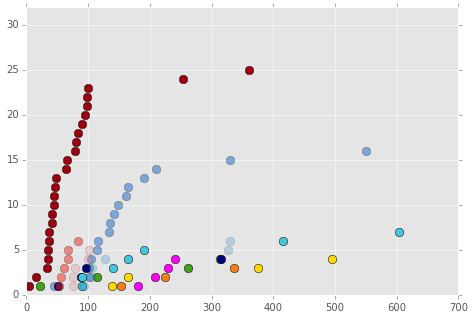

In [43]:


n_recs = 0
# for odor, stim in all_odors.iteritems():
#     #print odor
#     feat = litrals[litrals['stim'] == odor][prop]
#     #print feat
#     stim.plot_pars['marker'] = 'v'
#     ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
#     n_recs = max(n_recs, feat.shape[0])

# ax.set_ylim(0, n_recs+1)

# prop = 'spikes_inh'
# for odor, stim in all_odors.iteritems():
#     #print odor
#     feat = litrals[litrals['stim'] == odor][prop]
#     #print feat
#     stim.plot_pars['marker'] = '^'
#     ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
#     n_recs = max(n_recs, feat.shape[0])
    
prop = 'latency'
order = 'latency'
feature_fig = plt.figure()
ax = feature_fig.add_axes([0, 0, 1, 1])

responses_array.sort(order = order)
for odor, stim in all_odors.iteritems():
    #print odor
    feat = responses_array[(responses_array['litral'] == True) & (responses_array['stim'] == odor)][prop]
    #print feat
    stim.plot_pars['marker'] = 'o'
    stim.plot_pars['ms'] = 8
    ax.plot(feat, np.arange(1, feat.shape[0]+1), **stim.plot_pars)
    n_recs = max(n_recs, feat.shape[0])

ax.set_ylim(0, n_recs+1)

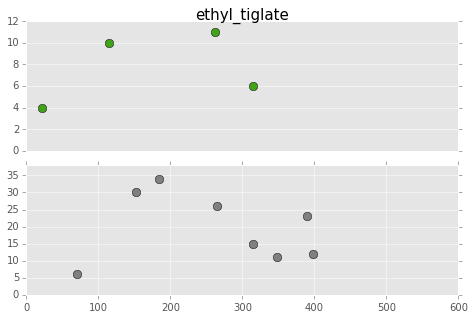

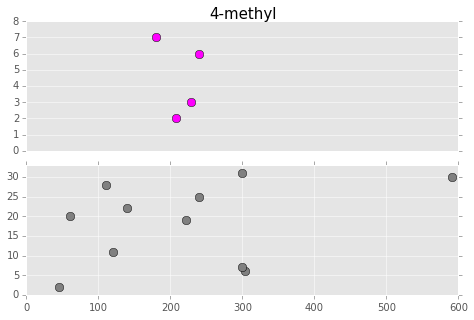

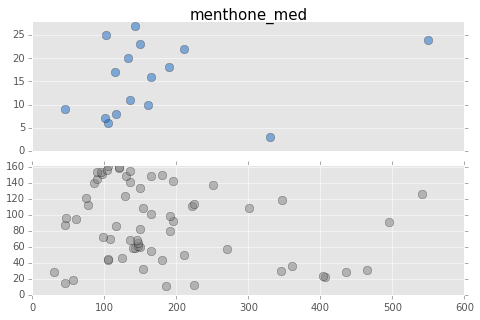

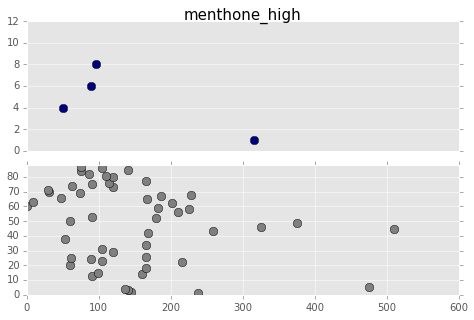

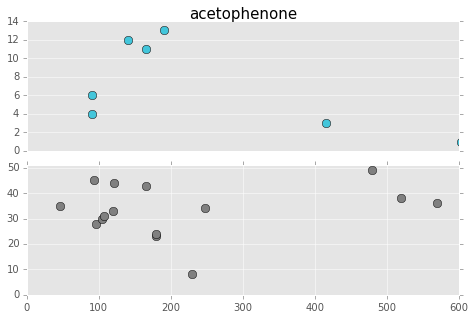

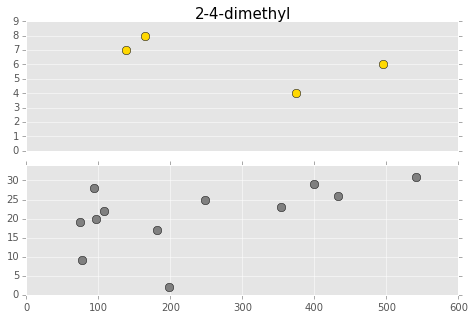

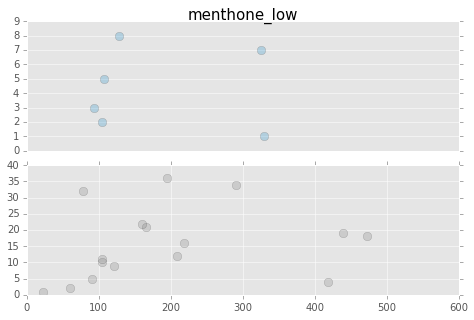

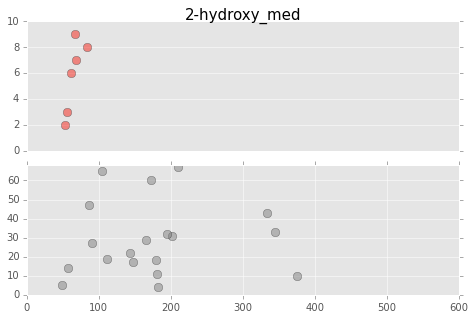

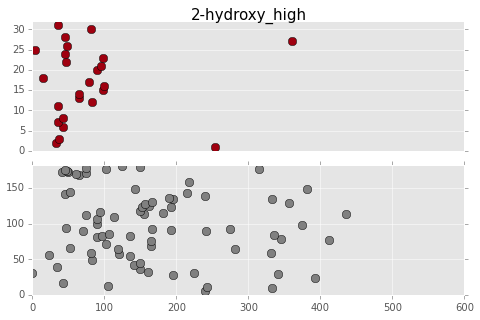

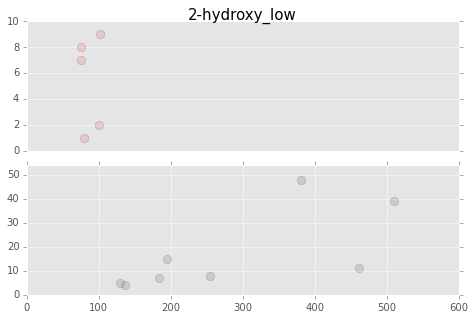

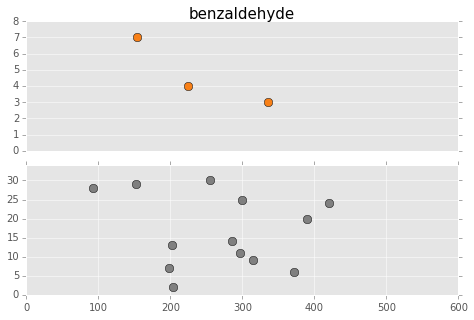

In [80]:
#plot for one stim, litral and population
from copy import deepcopy
def plot_one_stim(stim_name, stim, prop='latency', order='resp'):

    feat_fig = plt.figure()
    feat_fig.suptitle(stim_name, fontsize=15, y=1)
    ax_pop = feat_fig.add_axes([0, 0, 1, 0.45])
    ax_lit = feat_fig.add_axes([0, 0.5, 1, 0.45])
    ax_lit.get_xaxis().set_ticks([])

    responses_array.sort(order = order)

    #plot the litrals
    feat = responses_array[(responses_array['litral'] == True) & (responses_array['stim'] == stim_name)][prop]
    plot_pars = deepcopy(stim.plot_pars)
    plot_pars['marker'] = 'o'
    plot_pars['ms'] = 8
    ax_lit.plot(feat, np.arange(1, feat.shape[0]+1), **plot_pars)
    n_recs = feat.shape[0]
    ax_lit.set_ylim(0, n_recs+1)
    ax_lit.set_xlim(0,600)
    #plot the population
    feat = responses_array[(responses_array['litral'] == False) & (responses_array['stim'] == stim_name)][prop]
    plot_pars = deepcopy(stim.plot_pars)
    plot_pars['marker'] = 'o'
    plot_pars['ms'] = 8
    plot_pars['color'] = '#808080'
    ax_pop.plot(feat, np.arange(1, feat.shape[0]+1), **plot_pars)
    n_recs = feat.shape[0]
    ax_pop.set_ylim(0, n_recs+1)
    ax_pop.set_xlim(0,600)
    
    return feat_fig


odor = all_odors.keys()[10]
stim = all_odors[odor]

prop = 'latency'
order = 'resp'

for odor, stim in all_odors.iteritems():
    stim_fig = plot_one_stim(odor, stim, prop=prop, order=order)


In [62]:
feat_fig.axes[1].get_label()

u''

[]

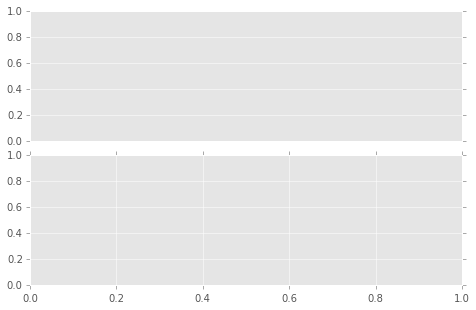

In [31]:
feat_fig = plt.figure()
ax_pop = feat_fig.add_axes([0, 0, 1, 0.45])
ax_lit = feat_fig.add_axes([0, 0.5, 1, 0.45])
ax_lit.get_xaxis().set_ticks([])

TypeError: iteritems() takes no arguments (1 given)